# 📎SVHN Datasets with PyTorch

## CNN

### Library

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from tqdm import tqdm
import os

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
# ------------------------------
# These hyperparameters have been chosen based on common practices for CNN models on SVHN
batch_size = 64        # Moderate batch size to balance between speed and memory
learning_rate = 0.001  # Standard starting learning rate for Adam optimizer
num_epochs = 10        # Reasonable number of epochs for demonstration purposes
num_classes = 10       # SVHN has 10 classes (digits 0-9)

Using device: cpu


### Datasets

In [3]:
# Data Loading and Preprocessing
# ------------------------------
# Define transformations for training data with augmentation
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),              # Resize to standard size
    transforms.RandomRotation(10),            # Slight rotation for augmentation
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Small translations
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Color augmentation
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Define transformations for test data (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the SVHN dataset
print("Downloading and loading SVHN dataset...")
# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

train_dataset = torchvision.datasets.SVHN(
    root='./data', split='train', download=True, transform=train_transform)
test_dataset = torchvision.datasets.SVHN(
    root='./data', split='test', download=True, transform=test_transform)

# Create data loaders
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


100%|██████████| 182M/182M [00:08<00:00, 21.7MB/s]
100%|██████████| 64.3M/64.3M [00:04<00:00, 13.6MB/s]


Training dataset size: 73257
Test dataset size: 26032


### Model

In [4]:
# CNN Model Architecture
# ------------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # First convolutional block
        # Input: 3x32x32 (RGB images with 32x32 pixels)
        # Output: 32x16x16
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),  # Batch normalization for stability
            nn.ReLU(),           # ReLU activation
            nn.MaxPool2d(kernel_size=2)  # Reduce spatial dimensions by half
        )

        # Second convolutional block
        # Input: 32x16x16
        # Output: 64x8x8
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Third convolutional block
        # Input: 64x8x8
        # Output: 128x4x4
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),  # Flatten the output from conv layers
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(512, num_classes)  # Output layer with 10 classes
        )

    def forward(self, x):
        # Pass input through convolutional blocks
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers
        x = self.fc(x)
        return x


# Initialize the model
model = SimpleCNN().to(device)
print(model)

# Loss function and optimizer
# ------------------------------
# CrossEntropyLoss combines LogSoftmax and NLLLoss, suitable for classification
criterion = nn.CrossEntropyLoss()
# Adam optimizer with standard learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout

### Training

In [5]:
# Training and Evaluation Functions
# ------------------------------
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


### Evaluation

In [6]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Get predictions
            softmax = nn.Softmax(dim=1)
            scores = softmax(outputs)
            _, predicted = torch.max(outputs.data, 1)

            # Store results
            running_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_scores.extend(scores.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_scores = np.array(all_scores)

    # Calculate metrics
    accuracy = np.mean(all_predictions == all_labels)
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    # For ROC and AUC, we need to binarize the labels (one-vs-rest approach)
    # and use the predicted probabilities
    roc_auc = calculate_multiclass_roc_auc(all_labels, all_scores)

    test_loss = running_loss / len(dataloader)

    metrics = {
        'loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': roc_auc,
        'labels': all_labels,
        'predictions': all_predictions,
        'scores': all_scores
    }

    return metrics


def calculate_multiclass_roc_auc(y_true, y_score):
    """Calculate ROC AUC for multiclass classification using one-vs-rest approach."""
    n_classes = y_score.shape[1]

    # Compute macro-average AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        # For each class, calculate binary classification metrics
        binary_labels = (y_true == i).astype(int)
        fpr[i], tpr[i], _ = roc_curve(binary_labels, y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average AUC
    macro_roc_auc = sum(roc_auc.values()) / n_classes

    return macro_roc_auc

In [7]:
# Training Loop
# ------------------------------
print("Starting training...")
train_losses = []
train_accs = []
val_metrics_history = {}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train the model
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print(f"Training: Loss = {train_loss:.4f}, Accuracy = {train_acc:.4f}")

    # Evaluate on test set
    val_metrics = evaluate(model, test_loader, criterion, device)

    # Store metrics history
    for metric, value in val_metrics.items():
        if metric not in ['labels', 'predictions', 'scores']:
            if metric not in val_metrics_history:
                val_metrics_history[metric] = []
            val_metrics_history[metric].append(value)

    print(f"Validation: Loss = {val_metrics['loss']:.4f}, "
          f"Accuracy = {val_metrics['accuracy']:.4f}, "
          f"Precision = {val_metrics['precision']:.4f}, "
          f"Recall = {val_metrics['recall']:.4f}, "
          f"F1 Score = {val_metrics['f1_score']:.4f}, "
          f"AUC = {val_metrics['auc']:.4f}")

print("Training complete!")


# Final Evaluation
# ------------------------------
print("\nPerforming final evaluation...")
final_metrics = evaluate(model, test_loader, criterion, device)

print("\nFinal Results:")
print(f"Test Loss: {final_metrics['loss']:.4f}")
print(f"Test Accuracy: {final_metrics['accuracy']:.4f}")
print(f"Test Precision: {final_metrics['precision']:.4f}")
print(f"Test Recall: {final_metrics['recall']:.4f}")
print(f"Test F1 Score: {final_metrics['f1_score']:.4f}")
print(f"Test AUC: {final_metrics['auc']:.4f}")


Starting training...

Epoch 1/10


Training: 100%|██████████| 1145/1145 [04:09<00:00,  4.59it/s]


Training: Loss = 1.5921, Accuracy = 0.4312


Evaluating: 100%|██████████| 407/407 [00:33<00:00, 12.01it/s]


Validation: Loss = 0.7856, Accuracy = 0.7588, Precision = 0.7475, Recall = 0.7148, F1 Score = 0.7108, AUC = 0.9606

Epoch 2/10


Training: 100%|██████████| 1145/1145 [03:58<00:00,  4.79it/s]


Training: Loss = 1.0641, Accuracy = 0.6274


Evaluating: 100%|██████████| 407/407 [00:33<00:00, 12.17it/s]


Validation: Loss = 0.5701, Accuracy = 0.8402, Precision = 0.8313, Recall = 0.8129, F1 Score = 0.8144, AUC = 0.9814

Epoch 3/10


Training: 100%|██████████| 1145/1145 [03:59<00:00,  4.78it/s]


Training: Loss = 0.8923, Accuracy = 0.6919


Evaluating: 100%|██████████| 407/407 [00:33<00:00, 12.28it/s]


Validation: Loss = 0.4452, Accuracy = 0.8701, Precision = 0.8691, Recall = 0.8465, F1 Score = 0.8546, AUC = 0.9871

Epoch 4/10


Training: 100%|██████████| 1145/1145 [03:57<00:00,  4.82it/s]


Training: Loss = 0.7984, Accuracy = 0.7297


Evaluating: 100%|██████████| 407/407 [00:35<00:00, 11.45it/s]


Validation: Loss = 0.4219, Accuracy = 0.8745, Precision = 0.8704, Recall = 0.8577, F1 Score = 0.8602, AUC = 0.9894

Epoch 5/10


Training: 100%|██████████| 1145/1145 [04:02<00:00,  4.73it/s]


Training: Loss = 0.7336, Accuracy = 0.7545


Evaluating: 100%|██████████| 407/407 [00:32<00:00, 12.64it/s]


Validation: Loss = 0.3650, Accuracy = 0.8987, Precision = 0.8959, Recall = 0.8828, F1 Score = 0.8878, AUC = 0.9911

Epoch 6/10


Training: 100%|██████████| 1145/1145 [04:02<00:00,  4.73it/s]


Training: Loss = 0.6847, Accuracy = 0.7723


Evaluating: 100%|██████████| 407/407 [00:32<00:00, 12.63it/s]


Validation: Loss = 0.3371, Accuracy = 0.9062, Precision = 0.9004, Recall = 0.8931, F1 Score = 0.8961, AUC = 0.9919

Epoch 7/10


Training: 100%|██████████| 1145/1145 [04:00<00:00,  4.75it/s]


Training: Loss = 0.6283, Accuracy = 0.7977


Evaluating: 100%|██████████| 407/407 [00:31<00:00, 12.72it/s]


Validation: Loss = 0.3188, Accuracy = 0.9078, Precision = 0.9049, Recall = 0.8945, F1 Score = 0.8987, AUC = 0.9926

Epoch 8/10


Training: 100%|██████████| 1145/1145 [04:00<00:00,  4.75it/s]


Training: Loss = 0.5813, Accuracy = 0.8166


Evaluating: 100%|██████████| 407/407 [00:32<00:00, 12.42it/s]


Validation: Loss = 0.2960, Accuracy = 0.9188, Precision = 0.9140, Recall = 0.9066, F1 Score = 0.9099, AUC = 0.9935

Epoch 9/10


Training: 100%|██████████| 1145/1145 [03:59<00:00,  4.77it/s]


Training: Loss = 0.5459, Accuracy = 0.8327


Evaluating: 100%|██████████| 407/407 [00:33<00:00, 12.28it/s]


Validation: Loss = 0.2893, Accuracy = 0.9209, Precision = 0.9158, Recall = 0.9115, F1 Score = 0.9131, AUC = 0.9941

Epoch 10/10


Training: 100%|██████████| 1145/1145 [03:58<00:00,  4.81it/s]


Training: Loss = 0.5002, Accuracy = 0.8466


Evaluating: 100%|██████████| 407/407 [00:33<00:00, 12.30it/s]


Validation: Loss = 0.2876, Accuracy = 0.9221, Precision = 0.9175, Recall = 0.9127, F1 Score = 0.9142, AUC = 0.9942
Training complete!

Performing final evaluation...


Evaluating: 100%|██████████| 407/407 [00:31<00:00, 12.78it/s]


Final Results:
Test Loss: 0.2876
Test Accuracy: 0.9221
Test Precision: 0.9175
Test Recall: 0.9127
Test F1 Score: 0.9142
Test AUC: 0.9942


### Visualisasi

Evaluation metrics figure saved as 'svhn_cnn_evaluation.png'


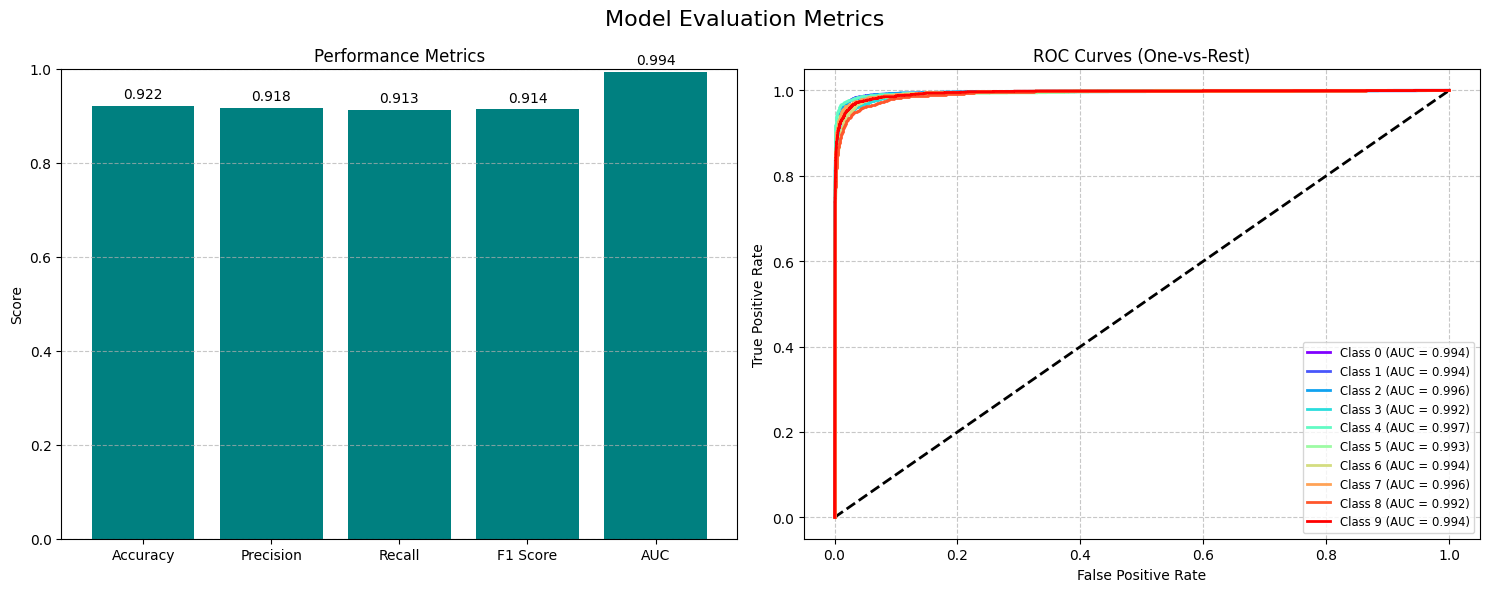

Model saved as 'svhn_cnn_model.pth'

Summary of the CNN model:
-------------------------
Architecture: 3 convolutional layers with batch normalization, followed by 2 fully connected layers
Parameters:
  - Learning rate: 0.001
  - Batch size: 64
  - Number of epochs: 10
  - Optimizer: Adam
  - Loss function: Cross Entropy Loss
Hyperparameter choices explanation:
  - Learning rate (0.001): Standard starting value for Adam optimizer, balancing speed and stability
  - Batch size (64): Moderate size to fit in memory while enabling efficient training
  - Convolutional layers: Increasing filters (32->64->128) to capture increasingly complex features
  - Dropout (0.5): Applied to fully connected layer to prevent overfitting
  - Data augmentation: Used to improve model generalization by creating variations of training images


In [8]:
# Visualization of Results
# ------------------------------
def plot_metrics(final_metrics):
    # Create a figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Model Evaluation Metrics', fontsize=16)

    # Bar chart of metrics
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
    metrics_values = [
        final_metrics['accuracy'],
        final_metrics['precision'],
        final_metrics['recall'],
        final_metrics['f1_score'],
        final_metrics['auc']
    ]

    bars = ax1.bar(metrics_names, metrics_values, color='teal')
    ax1.set_ylim(0, 1)
    ax1.set_title('Performance Metrics')
    ax1.set_ylabel('Score')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

    # Plot ROC curve for each class (one-vs-rest)
    ax2.set_title('ROC Curves (One-vs-Rest)')
    ax2.plot([0, 1], [0, 1], 'k--', lw=2)

    # Calculate and plot ROC curves for each class
    labels = final_metrics['labels']
    scores = final_metrics['scores']
    n_classes = scores.shape[1]

    colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

    for i, color in zip(range(n_classes), colors):
        # Binary labels for current class
        binary_labels = (labels == i).astype(int)

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(binary_labels, scores[:, i])
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        ax2.plot(fpr, tpr, color=color, lw=2,
                label=f'Class {i} (AUC = {roc_auc:.3f})')

    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend(loc='lower right', fontsize='small')
    ax2.grid(linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    # Save figure
    plt.savefig('svhn_cnn_evaluation.png', dpi=300, bbox_inches='tight')
    print("Evaluation metrics figure saved as 'svhn_cnn_evaluation.png'")

    # Show plot
    plt.show()


# Plot the final metrics
plot_metrics(final_metrics)

# Save the trained model
torch.save(model.state_dict(), 'svhn_cnn_model.pth')
print("Model saved as 'svhn_cnn_model.pth'")

print("\nSummary of the CNN model:")
print("-------------------------")
print("Architecture: 3 convolutional layers with batch normalization, followed by 2 fully connected layers")
print("Parameters:")
print(f"  - Learning rate: {learning_rate}")
print(f"  - Batch size: {batch_size}")
print(f"  - Number of epochs: {num_epochs}")
print(f"  - Optimizer: Adam")
print(f"  - Loss function: Cross Entropy Loss")
print("Hyperparameter choices explanation:")
print("  - Learning rate (0.001): Standard starting value for Adam optimizer, balancing speed and stability")
print("  - Batch size (64): Moderate size to fit in memory while enabling efficient training")
print("  - Convolutional layers: Increasing filters (32->64->128) to capture increasingly complex features")
print("  - Dropout (0.5): Applied to fully connected layer to prevent overfitting")
print("  - Data augmentation: Used to improve model generalization by creating variations of training images")

## MLP

### Library

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from tqdm import tqdm
import os

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
# ------------------------------
# These hyperparameters have been chosen based on common practices for MLP models on SVHN
batch_size = 128       # Larger batch size for MLP as we don't have to store feature maps
learning_rate = 0.001  # Standard starting learning rate for Adam optimizer
num_epochs = 15        # More epochs for MLP as it might need more time to converge
num_classes = 10       # SVHN has 10 classes (digits 0-9)

Using device: cpu


### Datasets

In [10]:
# Data Loading and Preprocessing
# ------------------------------
# Define transformations for training data
# Note: We use less augmentation for MLP as it doesn't have translation invariance
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),              # Resize to standard size
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Define transformations for test data
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the SVHN dataset
print("Downloading and loading SVHN dataset...")
# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

train_dataset = torchvision.datasets.SVHN(
    root='./data', split='train', download=True, transform=train_transform)
test_dataset = torchvision.datasets.SVHN(
    root='./data', split='test', download=True, transform=test_transform)

# Create data loaders
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 73257
Test dataset size: 26032


### Model

In [11]:
# MLP Model Architecture
# ------------------------------
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()

        # Input size: 3 channels * 32 * 32 = 3072 (flattened RGB image)
        self.flatten = nn.Flatten()

        # Sequential fully connected layers
        self.layers = nn.Sequential(
            # First hidden layer
            nn.Linear(3 * 32 * 32, 2048),
            nn.BatchNorm1d(2048),  # Batch normalization for stability
            nn.ReLU(),
            nn.Dropout(0.3),  # Moderate dropout for regularization

            # Second hidden layer
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            # Third hidden layer
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            # Output layer
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Flatten the input image
        x = self.flatten(x)

        # Pass through the fully connected layers
        x = self.layers(x)
        return x


# Initialize the model
model = SimpleMLP().to(device)
print(model)

# Loss function and optimizer
# ------------------------------
# CrossEntropyLoss combines LogSoftmax and NLLLoss, suitable for classification
criterion = nn.CrossEntropyLoss()
# Adam optimizer with standard learning rate and weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Learning rate scheduler to reduce learning rate on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


SimpleMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=512, out_features=10, bias=True)
  )
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Training

In [12]:
# Training and Evaluation Functions
# ------------------------------
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

### Evaluasi

In [13]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Get predictions
            softmax = nn.Softmax(dim=1)
            scores = softmax(outputs)
            _, predicted = torch.max(outputs.data, 1)

            # Store results
            running_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_scores.extend(scores.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_scores = np.array(all_scores)

    # Calculate metrics
    accuracy = np.mean(all_predictions == all_labels)
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    # For ROC and AUC, we need to binarize the labels (one-vs-rest approach)
    # and use the predicted probabilities
    roc_auc = calculate_multiclass_roc_auc(all_labels, all_scores)

    test_loss = running_loss / len(dataloader)

    metrics = {
        'loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': roc_auc,
        'labels': all_labels,
        'predictions': all_predictions,
        'scores': all_scores
    }

    return metrics


def calculate_multiclass_roc_auc(y_true, y_score):
    """Calculate ROC AUC for multiclass classification using one-vs-rest approach."""
    n_classes = y_score.shape[1]

    # Compute macro-average AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        # For each class, calculate binary classification metrics
        binary_labels = (y_true == i).astype(int)
        fpr[i], tpr[i], _ = roc_curve(binary_labels, y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average AUC
    macro_roc_auc = sum(roc_auc.values()) / n_classes

    return macro_roc_auc


# Training Loop
# ------------------------------
print("Starting training...")
train_losses = []
train_accs = []
val_metrics_history = {}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train the model
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print(f"Training: Loss = {train_loss:.4f}, Accuracy = {train_acc:.4f}")

    # Evaluate on test set
    val_metrics = evaluate(model, test_loader, criterion, device)

    # Adjust learning rate based on validation loss
    scheduler.step(val_metrics['loss'])

    # Store metrics history
    for metric, value in val_metrics.items():
        if metric not in ['labels', 'predictions', 'scores']:
            if metric not in val_metrics_history:
                val_metrics_history[metric] = []
            val_metrics_history[metric].append(value)

    print(f"Validation: Loss = {val_metrics['loss']:.4f}, "
          f"Accuracy = {val_metrics['accuracy']:.4f}, "
          f"Precision = {val_metrics['precision']:.4f}, "
          f"Recall = {val_metrics['recall']:.4f}, "
          f"F1 Score = {val_metrics['f1_score']:.4f}, "
          f"AUC = {val_metrics['auc']:.4f}")

print("Training complete!")


# Final Evaluation
# ------------------------------
print("\nPerforming final evaluation...")
final_metrics = evaluate(model, test_loader, criterion, device)

print("\nFinal Results:")
print(f"Test Loss: {final_metrics['loss']:.4f}")
print(f"Test Accuracy: {final_metrics['accuracy']:.4f}")
print(f"Test Precision: {final_metrics['precision']:.4f}")
print(f"Test Recall: {final_metrics['recall']:.4f}")
print(f"Test F1 Score: {final_metrics['f1_score']:.4f}")
print(f"Test AUC: {final_metrics['auc']:.4f}")


Starting training...

Epoch 1/15


Training: 100%|██████████| 573/573 [02:07<00:00,  4.48it/s]


Training: Loss = 1.4513, Accuracy = 0.5115


Evaluating: 100%|██████████| 204/204 [00:15<00:00, 13.57it/s]


Validation: Loss = 1.1205, Accuracy = 0.6439, Precision = 0.6526, Recall = 0.6111, F1 Score = 0.6191, AUC = 0.9198

Epoch 2/15


Training: 100%|██████████| 573/573 [02:07<00:00,  4.50it/s]


Training: Loss = 0.9782, Accuracy = 0.6888


Evaluating: 100%|██████████| 204/204 [00:15<00:00, 13.53it/s]


Validation: Loss = 0.9183, Accuracy = 0.7114, Precision = 0.6998, Recall = 0.6857, F1 Score = 0.6848, AUC = 0.9449

Epoch 3/15


Training: 100%|██████████| 573/573 [02:02<00:00,  4.69it/s]


Training: Loss = 0.8431, Accuracy = 0.7324


Evaluating: 100%|██████████| 204/204 [00:15<00:00, 13.56it/s]


Validation: Loss = 0.8251, Accuracy = 0.7516, Precision = 0.7389, Recall = 0.7274, F1 Score = 0.7293, AUC = 0.9557

Epoch 4/15


Training: 100%|██████████| 573/573 [02:04<00:00,  4.59it/s]


Training: Loss = 0.7692, Accuracy = 0.7574


Evaluating: 100%|██████████| 204/204 [00:14<00:00, 13.65it/s]


Validation: Loss = 0.7711, Accuracy = 0.7579, Precision = 0.7531, Recall = 0.7365, F1 Score = 0.7423, AUC = 0.9620

Epoch 5/15


Training: 100%|██████████| 573/573 [01:56<00:00,  4.94it/s]


Training: Loss = 0.7141, Accuracy = 0.7736


Evaluating: 100%|██████████| 204/204 [00:15<00:00, 13.39it/s]


Validation: Loss = 0.6987, Accuracy = 0.7855, Precision = 0.7806, Recall = 0.7610, F1 Score = 0.7675, AUC = 0.9679

Epoch 6/15


Training: 100%|██████████| 573/573 [02:05<00:00,  4.56it/s]


Training: Loss = 0.6790, Accuracy = 0.7858


Evaluating: 100%|██████████| 204/204 [00:15<00:00, 13.45it/s]


Validation: Loss = 0.6688, Accuracy = 0.7959, Precision = 0.7860, Recall = 0.7760, F1 Score = 0.7787, AUC = 0.9706

Epoch 7/15


Training: 100%|██████████| 573/573 [02:09<00:00,  4.43it/s]


Training: Loss = 0.6498, Accuracy = 0.7943


Evaluating: 100%|██████████| 204/204 [00:15<00:00, 13.56it/s]


Validation: Loss = 0.6472, Accuracy = 0.8038, Precision = 0.7893, Recall = 0.7869, F1 Score = 0.7857, AUC = 0.9728

Epoch 8/15


Training: 100%|██████████| 573/573 [02:06<00:00,  4.53it/s]


Training: Loss = 0.6285, Accuracy = 0.8015


Evaluating: 100%|██████████| 204/204 [00:14<00:00, 13.61it/s]


Validation: Loss = 0.6232, Accuracy = 0.8097, Precision = 0.8058, Recall = 0.7884, F1 Score = 0.7947, AUC = 0.9746

Epoch 9/15


Training: 100%|██████████| 573/573 [02:06<00:00,  4.54it/s]


Training: Loss = 0.6077, Accuracy = 0.8072


Evaluating: 100%|██████████| 204/204 [00:15<00:00, 13.37it/s]


Validation: Loss = 0.6190, Accuracy = 0.8166, Precision = 0.8079, Recall = 0.7992, F1 Score = 0.8023, AUC = 0.9743

Epoch 10/15


Training: 100%|██████████| 573/573 [02:09<00:00,  4.42it/s]


Training: Loss = 0.5934, Accuracy = 0.8119


Evaluating: 100%|██████████| 204/204 [00:15<00:00, 12.81it/s]


Validation: Loss = 0.6373, Accuracy = 0.7997, Precision = 0.7869, Recall = 0.7838, F1 Score = 0.7814, AUC = 0.9736

Epoch 11/15


Training: 100%|██████████| 573/573 [02:07<00:00,  4.51it/s]


Training: Loss = 0.5799, Accuracy = 0.8162


Evaluating: 100%|██████████| 204/204 [00:14<00:00, 13.64it/s]


Validation: Loss = 0.5798, Accuracy = 0.8250, Precision = 0.8207, Recall = 0.8053, F1 Score = 0.8119, AUC = 0.9776

Epoch 12/15


Training: 100%|██████████| 573/573 [02:04<00:00,  4.61it/s]


Training: Loss = 0.5589, Accuracy = 0.8231


Evaluating: 100%|██████████| 204/204 [00:15<00:00, 13.45it/s]


Validation: Loss = 0.5991, Accuracy = 0.8141, Precision = 0.8062, Recall = 0.7989, F1 Score = 0.8013, AUC = 0.9766

Epoch 13/15


Training: 100%|██████████| 573/573 [02:01<00:00,  4.72it/s]


Training: Loss = 0.5538, Accuracy = 0.8252


Evaluating: 100%|██████████| 204/204 [00:15<00:00, 13.22it/s]


Validation: Loss = 0.6074, Accuracy = 0.8160, Precision = 0.8006, Recall = 0.8007, F1 Score = 0.7993, AUC = 0.9751

Epoch 14/15


Training: 100%|██████████| 573/573 [01:59<00:00,  4.80it/s]


Training: Loss = 0.5383, Accuracy = 0.8286


Evaluating: 100%|██████████| 204/204 [00:15<00:00, 13.44it/s]


Validation: Loss = 0.5746, Accuracy = 0.8219, Precision = 0.8162, Recall = 0.8044, F1 Score = 0.8080, AUC = 0.9784

Epoch 15/15


Training: 100%|██████████| 573/573 [01:59<00:00,  4.78it/s]


Training: Loss = 0.5340, Accuracy = 0.8313


Evaluating: 100%|██████████| 204/204 [00:19<00:00, 10.66it/s]


Validation: Loss = 0.5620, Accuracy = 0.8278, Precision = 0.8239, Recall = 0.8096, F1 Score = 0.8149, AUC = 0.9793
Training complete!

Performing final evaluation...


Evaluating: 100%|██████████| 204/204 [00:16<00:00, 12.49it/s]



Final Results:
Test Loss: 0.5620
Test Accuracy: 0.8278
Test Precision: 0.8239
Test Recall: 0.8096
Test F1 Score: 0.8149
Test AUC: 0.9793


### Visualisasi

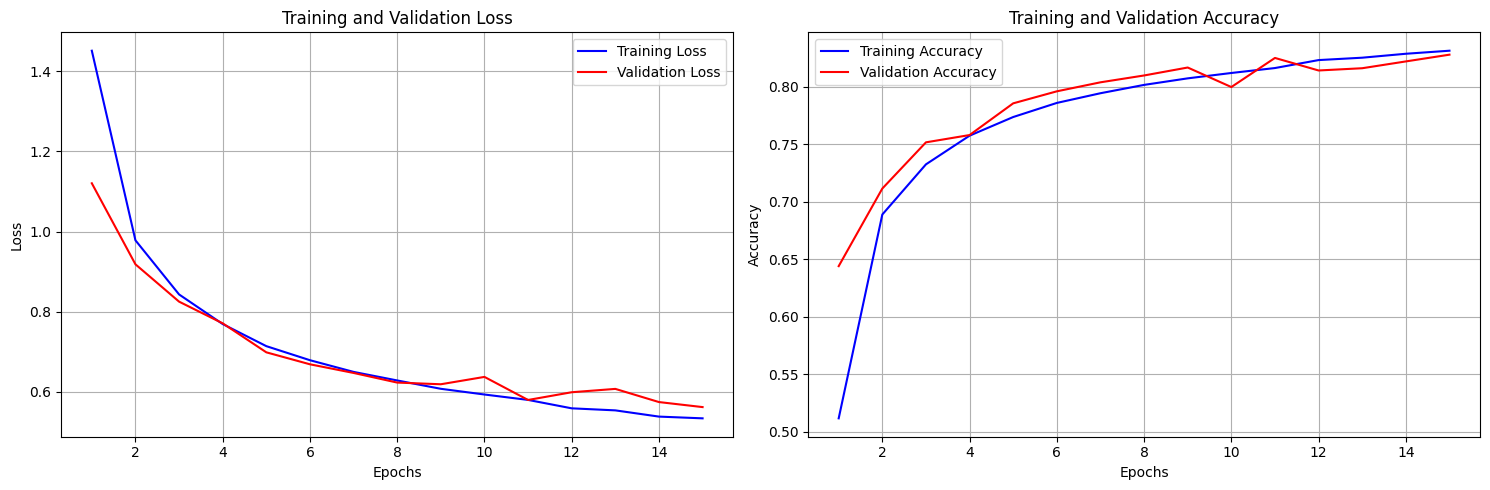

Evaluation metrics figure saved as 'svhn_mlp_evaluation.png'


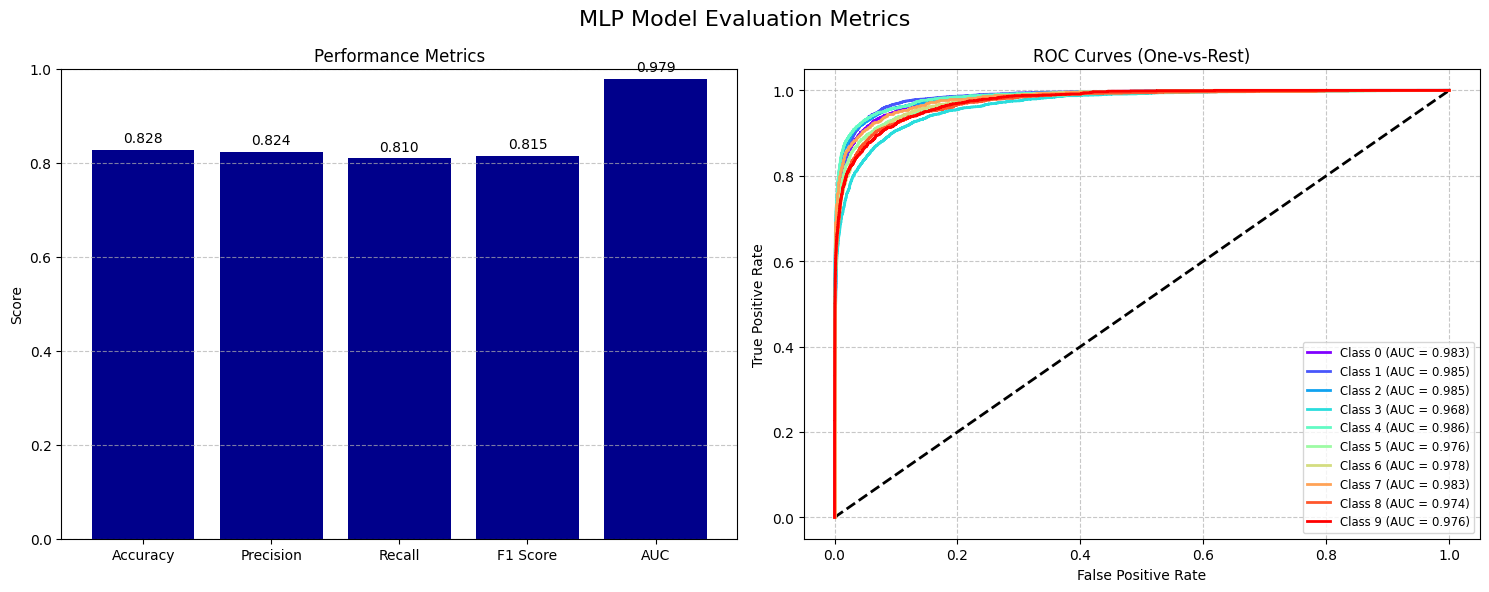

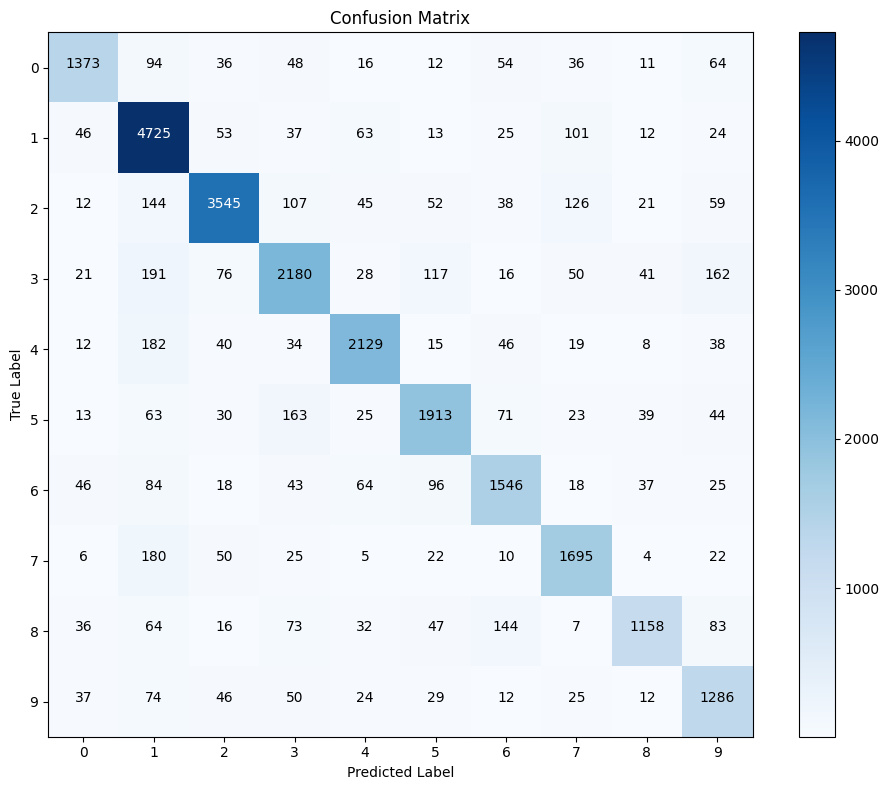

Model saved as 'svhn_mlp_model.pth'

Summary of the MLP model:
-------------------------
Architecture: 3 fully connected hidden layers with batch normalization and dropout
Parameters:
  - Learning rate: 0.001 (with ReduceLROnPlateau scheduler)
  - Batch size: 128
  - Number of epochs: 15
  - Optimizer: Adam with weight decay
  - Loss function: Cross Entropy Loss
Hyperparameter choices explanation:
  - Learning rate (0.001): Standard starting value for Adam optimizer
  - Larger batch size (128): MLPs can handle larger batches compared to CNNs
  - Weight decay (1e-5): Additional regularization to prevent overfitting
  - Dropout rates (0.3-0.4): Moderate dropout to prevent overfitting
  - Network architecture (3072→2048→1024→512→10): Gradually decreasing layer sizes to extract features
  - Learning rate scheduler: Reduces LR when validation loss plateaus to fine-tune weights
  - More epochs (15): MLPs typically need more training iterations compared to CNNs


In [14]:
# Training Progress Visualization
# ------------------------------
def plot_training_progress(train_losses, train_accs, val_metrics_history):
    """Plot the training and validation metrics over epochs."""
    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_metrics_history['loss'], 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_metrics_history['accuracy'], 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('svhn_mlp_training_progress.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot training progress
plot_training_progress(train_losses, train_accs, val_metrics_history)


# Visualization of Results
# ------------------------------
def plot_metrics(final_metrics):
    # Create a figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('MLP Model Evaluation Metrics', fontsize=16)

    # Bar chart of metrics
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
    metrics_values = [
        final_metrics['accuracy'],
        final_metrics['precision'],
        final_metrics['recall'],
        final_metrics['f1_score'],
        final_metrics['auc']
    ]

    bars = ax1.bar(metrics_names, metrics_values, color='darkblue')
    ax1.set_ylim(0, 1)
    ax1.set_title('Performance Metrics')
    ax1.set_ylabel('Score')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

    # Plot ROC curve for each class (one-vs-rest)
    ax2.set_title('ROC Curves (One-vs-Rest)')
    ax2.plot([0, 1], [0, 1], 'k--', lw=2)

    # Calculate and plot ROC curves for each class
    labels = final_metrics['labels']
    scores = final_metrics['scores']
    n_classes = scores.shape[1]

    colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

    for i, color in zip(range(n_classes), colors):
        # Binary labels for current class
        binary_labels = (labels == i).astype(int)

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(binary_labels, scores[:, i])
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        ax2.plot(fpr, tpr, color=color, lw=2,
                label=f'Class {i} (AUC = {roc_auc:.3f})')

    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend(loc='lower right', fontsize='small')
    ax2.grid(linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    # Save figure
    plt.savefig('svhn_mlp_evaluation.png', dpi=300, bbox_inches='tight')
    print("Evaluation metrics figure saved as 'svhn_mlp_evaluation.png'")

    # Show plot
    plt.show()


# Plot the final metrics
plot_metrics(final_metrics)

# Visualize confusion matrix
def plot_confusion_matrix(labels, predictions):
    cm = confusion_matrix(labels, predictions)

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = range(10)  # 0-9 digits
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Add text annotations to each cell
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

    # Save figure
    plt.savefig('svhn_mlp_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(final_metrics['labels'], final_metrics['predictions'])

# Save the trained model
torch.save(model.state_dict(), 'svhn_mlp_model.pth')
print("Model saved as 'svhn_mlp_model.pth'")

print("\nSummary of the MLP model:")
print("-------------------------")
print("Architecture: 3 fully connected hidden layers with batch normalization and dropout")
print("Parameters:")
print(f"  - Learning rate: {learning_rate} (with ReduceLROnPlateau scheduler)")
print(f"  - Batch size: {batch_size}")
print(f"  - Number of epochs: {num_epochs}")
print(f"  - Optimizer: Adam with weight decay")
print(f"  - Loss function: Cross Entropy Loss")
print("Hyperparameter choices explanation:")
print("  - Learning rate (0.001): Standard starting value for Adam optimizer")
print("  - Larger batch size (128): MLPs can handle larger batches compared to CNNs")
print("  - Weight decay (1e-5): Additional regularization to prevent overfitting")
print("  - Dropout rates (0.3-0.4): Moderate dropout to prevent overfitting")
print("  - Network architecture (3072→2048→1024→512→10): Gradually decreasing layer sizes to extract features")
print("  - Learning rate scheduler: Reduces LR when validation loss plateaus to fine-tune weights")
print("  - More epochs (15): MLPs typically need more training iterations compared to CNNs")